## Imports

In [1]:
# Imports
%matplotlib notebook
import torch, time
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

## General parameters

We define various parameters and hyperparameters. 

In [3]:
# Hardware (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20 # Nodes in the hidden layer

# Physical parameters
Z = 50 # atomic number
alpha = 7.297e-3

# Network parameters.
seed = 42 # Define the seed 
torch.manual_seed(seed)
# Determine the coefficients for NN (3 layers)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-0.1) 
B1 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W2 = torch.rand(Nhid, Nhid, requires_grad=True)* (-0.1)        
B2 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W3 = torch.rand(Nout, Nhid, requires_grad=True)* (0.1)    

# Training hyperparameters
epochs = 50000
lr = 1e-4  # Learning rate

# Mesh parameters
Nr = 10000                   # Mesh division
train_a = 0                    
train_b = 80

h = (train_b - train_a) / (Nr - 1)  # Grid step
wi = torch.empty(Nr, 1).fill_(h).to(device) # Integration weights for this mesh. Dirichlet boundary conditions 
Y_train = torch.linspace(train_a+h, train_b, Nr, requires_grad=True, device=device)      

For Z=1

In [4]:
# Hardware (CPU or GPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network hyperparameters
#Nin = 1   # Inputs to the neural network
#Nout = 1  # Outputs of the neural network
#Nhid = 20  # Nodes in the hidden layer

# Physical parameters
#Z = 1 # atomic number
#alpha = 7.297e-3

# Network parameters.
#seed = 42 # Define the seed 
#torch.manual_seed(seed)
# Determine the coefficients for NN (3 layers)
#W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-0.01) 
#B1 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
#W2 = torch.rand(Nhid, Nhid, requires_grad=True)* (-0.01)        
#B2 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
#W3 = torch.rand(Nout, Nhid, requires_grad=True)* (-0.01)    

# Training hyperparameters
#epochs = 15000
#lr = 2e-5  # Learning rate

# Mesh parameters
#Nr = 10000                   # Mesh division
#train_a = 0                    
#train_b = 3500

#h = (train_b - train_a) / (Nr - 1)  # Grid step
#wi = torch.empty(Nr, 1).fill_(h).to(device) # Integration weights for this mesh. Dirichlet boundary conditions 
#Y_train = torch.linspace(train_a+h, train_b, Nr, requires_grad=True, device=device)   

The hydrogenlike atom can be solved analytically. The general form of the solutions is long, but since we are only interested in the radial coordinate $r$, we will write down the form of some functions $P_{nl}(r)$ for some values $n, l$:

$$ P_{10}(r) = 2Z^{3/2}re^{-Zr}, $$

$$ P_{20}(r) = \frac{1}{\sqrt{2}}Z^{3/2}r\bigg(1-\frac{1}{2}Zr\bigg)e^{-Zr/2}, $$

$$ P_{21}(r) = \frac{1}{2\sqrt{6}}Z^{5/2}r^2e^{-Zr/2}. $$

Below is a simple Python implementation of these functions, which we will use later for comparative analysis.

<IPython.core.display.Javascript object>


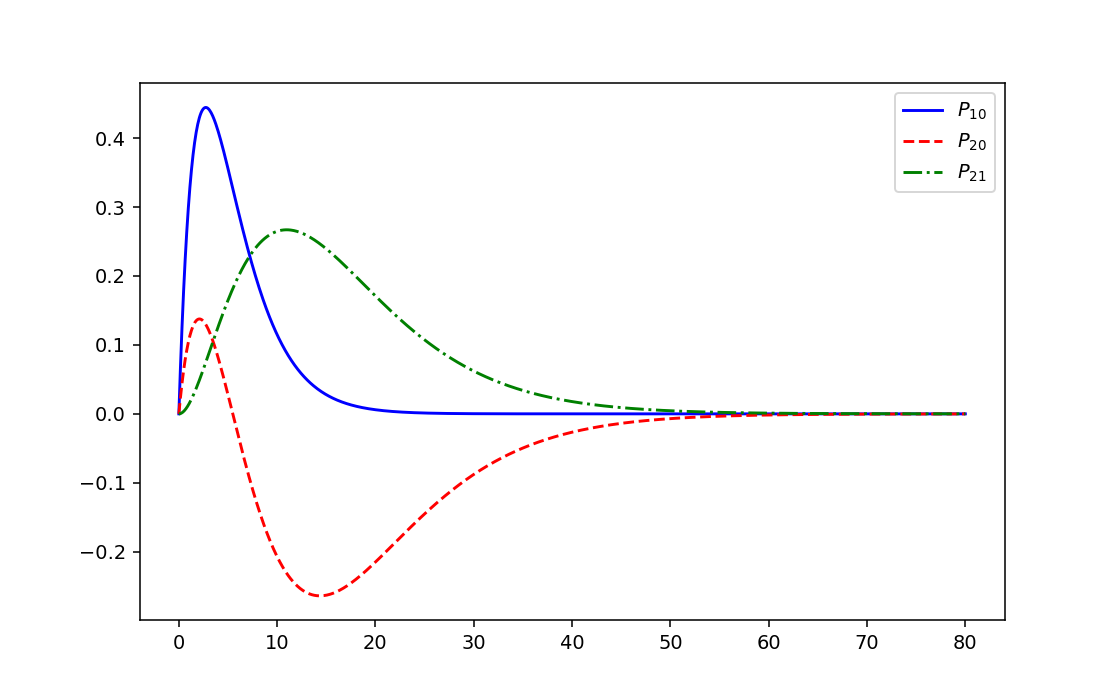

In [5]:
P_10 = lambda r : 2.*np.power(Z*alpha, 1.5)*r*np.exp(-Z*r*alpha)
P_20 = lambda r : (1/np.sqrt(2.))*np.power(Z*alpha, 1.5)*r*(1-0.5*Z*alpha*r)*np.exp(-Z*alpha*r/2.)
P_21 = lambda r : (1/(2*np.sqrt(6.)))*np.power(Z*alpha, 2.5)*np.power(r, 2)*np.exp(-alpha*Z*r/2.)
d1 = 0.5 - np.sqrt(0.25-Z**2*alpha**2) 
d2 = 1.5 - np.sqrt(1.5**2-Z**2*alpha**2)
E0_th = 1/np.sqrt(1+Z**2*alpha**2/(1-d1)**2)-1
E1_th = 1/np.sqrt(1+Z**2*alpha**2/(2-d2)**2)-1
E2_th = 1/np.sqrt(1+Z**2*alpha**2/(2-d1)**2)-1
#E0_th = -2.664e-5*Z**2
#E1_th = -6.66e-6*Z**2

r_grid = np.linspace(train_a, train_b, 1000)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(r_grid, P_10(r_grid), color='b', label='$P_{10}$')
ax.plot(r_grid, P_20(r_grid), color='r', linestyle='--', label='$P_{20}$')
ax.plot(r_grid, P_21(r_grid), color='g', linestyle='-.', label='$P_{21}$')
ax.legend()
fig.canvas.draw()
time.sleep(0.1)

## The neural network

In [6]:
class NNQS(nn.Module):
    def __init__(self, W1, B1, W2, B2, W3):
        super().__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)  
        self.actfun = nn.Tanh()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nhid, 
                             bias=True) 
        self.actfun2 = nn.Tanh()        # activation function
        self.lc3 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=True)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B1)
            self.lc2.bias = nn.Parameter(B2)
            self.lc2.weight = nn.Parameter(W2)
            self.lc3.weight = nn.Parameter(W3)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc3(self.actfun2(self.lc2(self.actfun(self.lc1(x)))))
        return o
    
net = NNQS(W1, B1, W2, B2, W3).to(device)

In [7]:
optimizer = torch.optim.AdamW(params=net.parameters(), lr=lr)

## The loss function

The loss function is calculated as follows

$$ m = 1, c = 1, \hbar = 1, e = \alpha  $$

$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_{nl,\theta}}\hat{H}_{eff}\ket{\psi_{nl,\theta}}}{\bra{\psi_{nl,\theta}}\psi_{nl,\theta}\rangle} + L_{2,regul}. $$

$$ \hat{H}_{eff} = -\frac{1}{2}\frac{d^2}{dx^2} +\frac{1}{2r^2}l(l+1)+ V_{eff}$$

$$ E_{eff} = \frac{E^2-1}{2} $$
$$ V_{eff} = \frac{2EV(x)-V^2(x)}{2} $$


Since we are working in spherical coordinates and given that the interaction is Coulombian, the above integrals

$$ \bra{\psi_{nl,\theta}}\hat{H}_{eff}\ket{\psi_{nl,\theta}} = \int_0^\infty \bigg\{\frac{1}{2}\bigg(\frac{d\psi_{nl,\theta}(r)}{dr}\bigg)^2+\psi_{nl,\theta}^2(r)(\frac{1}{2r^2}l(l+1)+ V_{eff})\bigg\}dr $$

With discretization
$$ \bra{\psi_{nl,\theta}}\hat{H}_{eff}\ket{\psi_{nl,\theta}} \approx \sum_{i=1}^{N_r} w_i \bigg[\frac{1}{2}\bigg(\frac{d\psi_{nl,\theta}(r_i)}{dr}\bigg)^2+\psi_{nl,\theta}^2(r_i)(\frac{1}{2r^2}l(l+1)+ V_{eff})\bigg], $$

$$\bra{\psi_{nl,\theta}}\psi_{nl,\theta}\rangle\approx \sum_{i=1}^{N_r} w_i \psi_{nl,\theta}^2(r_i)\equiv N.$$

At this stage, we take an additional step and add the *envelope* to the NNQS when calculating losses. The envelope is a function that multiplies NNQS, and its purpose is to impose boundary conditions. In our case, we should require that $\psi_{nl}(0)=0$, and we can achieve this in exactly the same way as it would be done analytically:

$$ \psi_{nl}(r)r^{l+1} \longleftarrow \psi_{nl}(r) $$
We use $(\frac{1}{2r^2}l(l+1)+ V_{eff})$ as $V_{eff}$. 

In [8]:
def loss_fn(l, E): 
    lambd = 1e-4
    X_det = X.clone().detach()
    psi = net(X)*X.pow(l+1)
    psi2 = (net(X_det)*X_det.pow(l+1)).pow(2)
    dpsi_dr, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)   
    N = torch.tensordot(psi2, wi) 
    U_eff = torch.tensordot(psi2 * ( - E*alpha*Z/X_det + l*(l+1)/(2*X_det.pow(2)) - (alpha*Z)**2/(2*X_det.pow(2)) ), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N
    regul = torch.tensordot(net.lc1.weight,net.lc1.weight) 
    + torch.tensordot(net.lc2.weight,net.lc2.weight) + torch.tensordot(net.lc3.weight,net.lc3.weight) # regularization
    
    return K + U_eff + lambd*regul, U_eff, K, psi, psi / torch.sqrt(N)

## Plotting

In [9]:
def pic(i, l, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized wavefunction')
    wf = psi_normalized.detach().cpu().numpy()
    if net(torch.tensor([[-2.]]).to(device)).item() < 0.: wf *= -1
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    try: 
        ax1.set_ylim(lim_inf, lim_sup) 
    except: 
        pass
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NNQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{Sh}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS wavefunction')
    wf = psi.detach().cpu().numpy()
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    try: 
        ax2.set_ylim(lim_inf, lim_sup)
    except:
        pass
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.full(i+1, E0_th if l == 0 else E1_th)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U_{eff}$', color='green')
        ax3.plot(x, K, label='$K$', color='gold')
        ax3.plot(x, np.full(i+1, E0_th if l == 0 else E1_th) , linestyle='--', label='$E_{theory}$', color='r')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: $\ket{\psi_{10}}, \ket{\psi_{21}}$

<IPython.core.display.Javascript object>


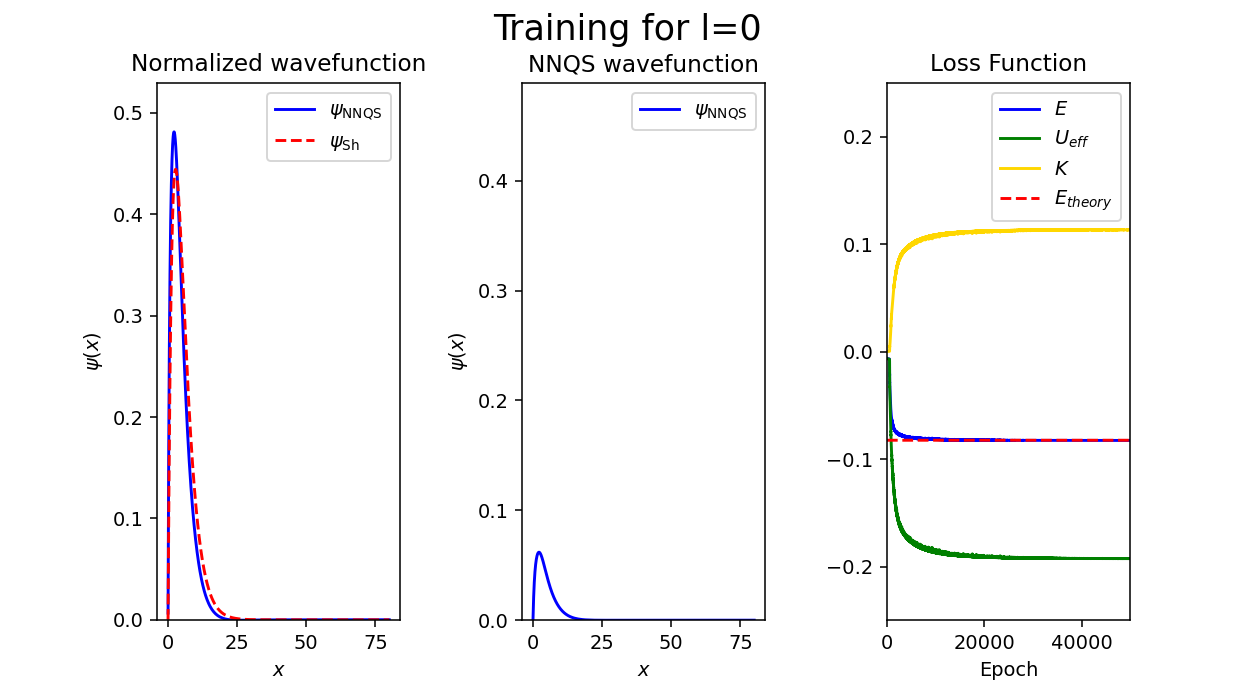

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 50000/50000 [04:09<00:00, 200.27it/s]


<IPython.core.display.Javascript object>


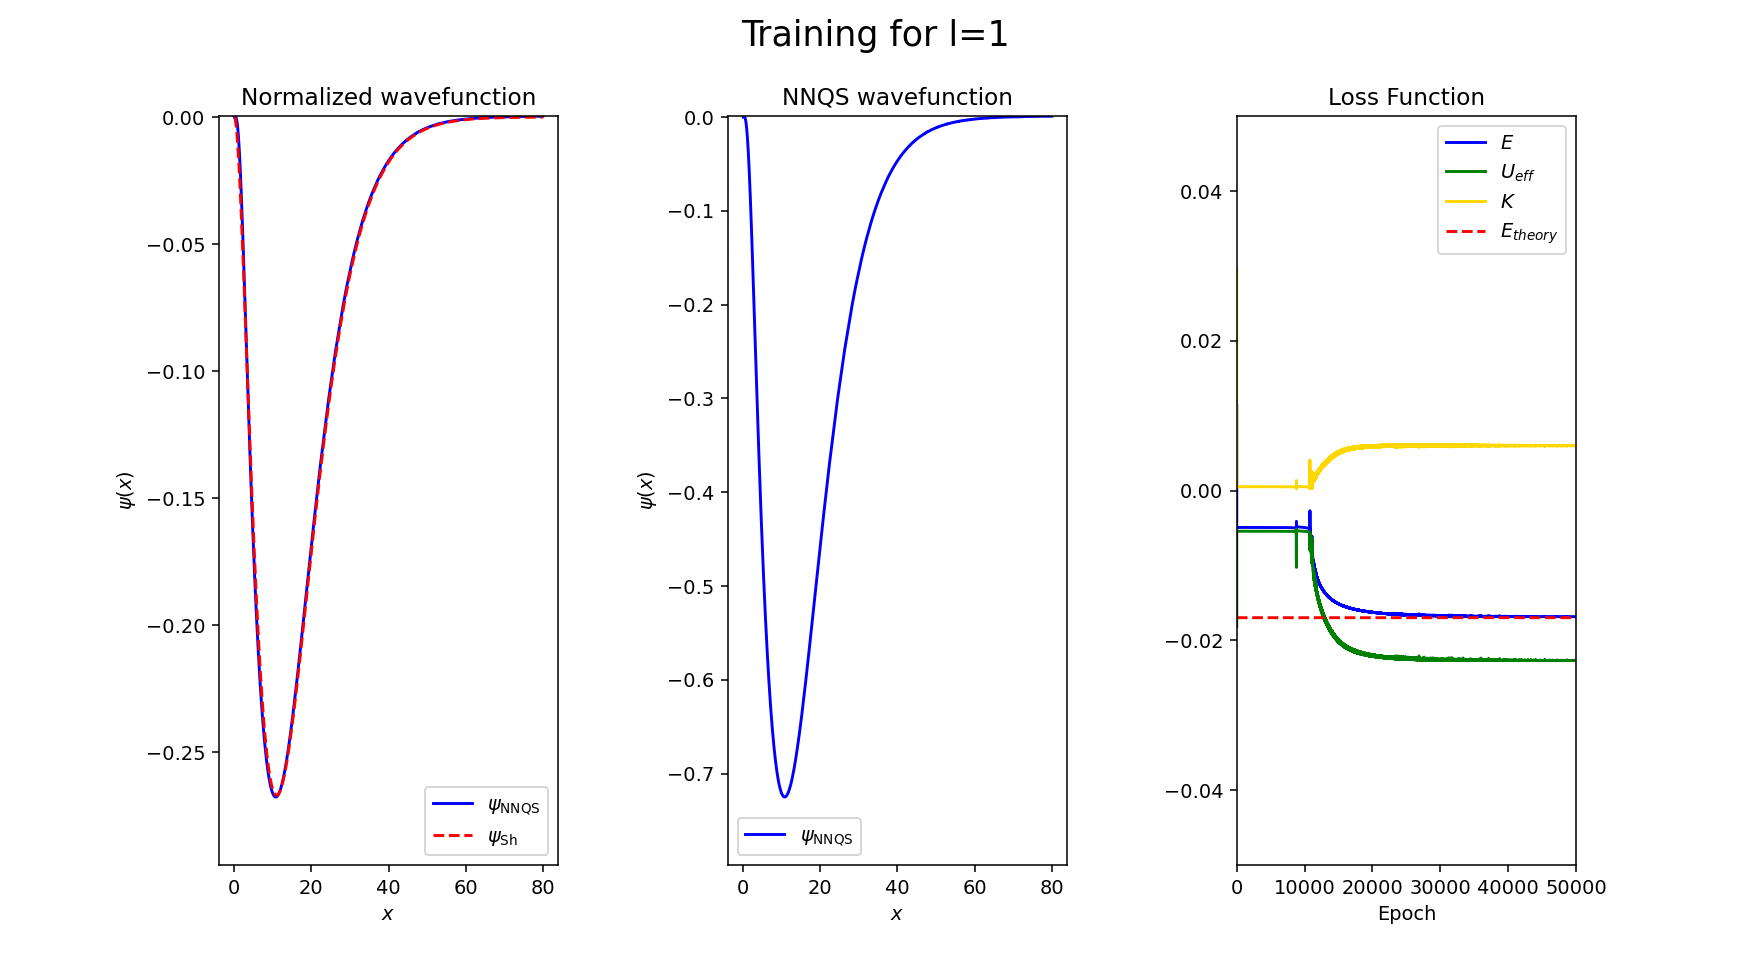

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 50000/50000 [03:55<00:00, 212.70it/s]


In [10]:
set_random_seed(seed)

X = Y_train.clone().unsqueeze(1)
r_grid = np.linspace(train_a, train_b, 10000)

lambda1 = lambda epoch: 0.9999 ** epoch

# Traninig for l=0,1
for l in [0,1]:
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)
    
    # Plotting
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
    fig.suptitle(f'Training for l={l}', fontsize=18)
    ax1, ax2, ax3 = ax[0], ax[1], ax[2]
    plt.subplots_adjust(wspace=0.5)

    # Overlap
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$\psi(x)$")

    # Wave function
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$\psi(x)$")

    # Loss
    ax3.set_xlabel("Epoch")
    if l == 0: ax3.set_ylim(-0.0001*Z**2, 0.0001*Z**2)
    if l == 1: ax3.set_ylim(-0.00002*Z**2, 0.00002*Z**2)

    loss_accum = []
    U_accum = []
    K_accum = []
    
    if l == 0:
        target = P_10(r_grid)
    elif l == 1:
        target = -P_21(r_grid)
        
    #init E 
    E = 0.99

    # Training loop
    for i in tqdm(range(epochs), desc="Training the NNQS..."):
        loss, U, K, psi, psi_normalized = loss_fn(l, E)    # Energy and \psi calculation
        E = torch.sqrt(2*(K+U)+1).clone().detach()
        
        

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters
        
        scheduler.step()   #scheduler

        loss_accum.append((E-1).item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1) or (i % 200 == 0): # We plot periodically
            pic(i, l, Y_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
            time.sleep(0.01)
        if l == 0:
            E_10, psi_10 = loss_accum[-1], psi.clone().detach()
        elif l == 1:
            E_21, psi_21 = loss_accum[-1], psi.clone().detach()

Now let's move on to the first excited state. The process is almost identical to the process of finding the ground state wave function, with 

$$ \langle\psi_{10,\theta}|\psi_{20,\theta'}\rangle = 0, $$

where $\psi_{10,\theta}, \psi_{20,\theta'}$ are the wave functions of the paragraph of the ground and first excited states, respectively. The obvious way to impose this condition is to add it to the loss function using a Lagrange multiplier:

$$ \mathcal{L'} = \frac{\langle{\psi_{20,\theta'}}|\hat{H}_{eff}|{\psi_{20,\theta'}}\rangle}{\langle\psi_{20,\theta'}|\psi_{20,\theta'}\rangle} + \lambda\frac{\langle\psi_{\theta,10}|\psi_{20,\theta'}\rangle^2}{\langle\psi_{20,\theta'}|\psi_{20,\theta'}\rangle\langle\psi_{10,\theta}|\psi_{10,\theta}\rangle} + L_{2,regul}, $$

where $\lambda$ is the Lagrange multiplier. 

In [11]:
def loss_fn_prime(l, E):  
    lambd = 1e-4
    X_det = X.clone().detach()
    psi = net1(X)*X.pow(l+1)
    psi2 = (net1(X_det)*X_det.pow(l+1)).pow(2)
    dpsi_dr, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)   
    N = torch.tensordot(psi2, wi) 
    U_eff = torch.tensordot(psi2 * ( - E*alpha*Z/X_det + l*(l+1)/(2*X_det.pow(2)) - (alpha*Z)**2/(2*X_det.pow(2)) ), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N
    
    # Overlap term
    num = (torch.tensordot(psi*psi_10, wi)).pow(2)
    den = (torch.tensordot(psi2, wi)) * (torch.tensordot(psi_10.pow(2), wi))
    O = lambda_ * (num / den)
    regul = torch.tensordot(net1.lc1.weight,net1.lc1.weight) 
    + torch.tensordot(net1.lc2.weight,net1.lc2.weight) + torch.tensordot(net1.lc3.weight,net1.lc3.weight) #regularization
    
    

    return K + U_eff + O +lambd*regul, U_eff, K, psi, psi / torch.sqrt(N)

In [12]:
# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20 # Nodes in the hidden layer

l = 0

# Network parameters.
seed = 42
torch.manual_seed(seed)
lr = 2e-4
lambda_ = 0.5

net1 = NNQS(W1, B1, W2, B2, W3).to(device)
optimizer = torch.optim.AdamW(params=net1.parameters(), lr=lr)
epochs = 60000

We are defining a new plotting function,

In [13]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized wavefunction')
    wf = psi_normalized.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() < 0.: wf *= -1
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    ax1.set_ylim(lim_inf, lim_sup)
    if ax1.lines:
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(r_grid)
        ax1.lines[1].set_ydata(target)
    else:
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(r_grid, target, linestyle="--", 
                 label='$\psi_\mathrm{Sh}$', color='r')
        ax1.plot()
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS wavefunction')
    wf = psi.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() < 0.: wf *= -1
    lim_inf = min(np.min(wf)*1.1, np.min(target)*1.1)
    lim_sup = max(np.max(wf)*1.1, np.max(target)*1.1)
    ax2.set_ylim(lim_inf, lim_sup)
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    ax3.set_ylim(-0.00002*Z**2, 0.00002*Z**2)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E2_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U_{eff}$', color='green')
        ax3.plot(x, K, label='$K$', color='gold')
        ax3.plot(x, np.ones(i+1)*E2_th, linestyle='--', label='$E_{theory}$', color='r')
        ax3.legend()
        
    fig.canvas.draw()

<IPython.core.display.Javascript object>


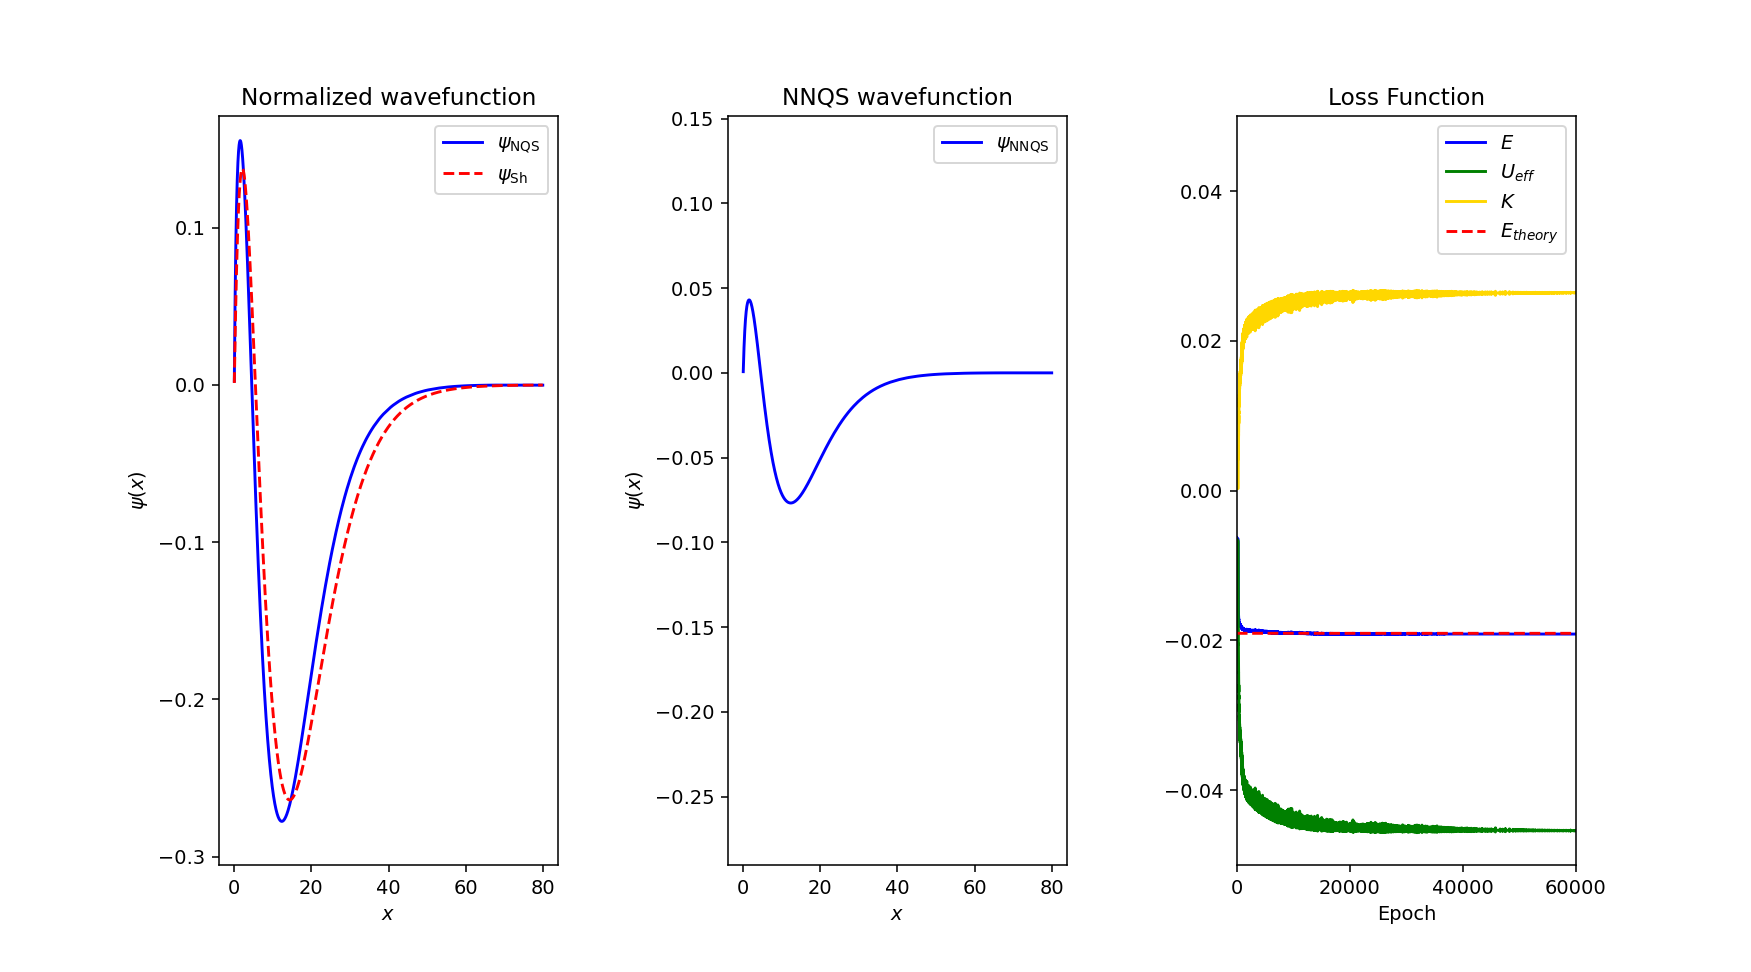

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 60000/60000 [06:06<00:00, 163.83it/s]


In [14]:
set_random_seed(seed)

lambda1 = lambda epoch: 0.9999 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")

loss_accum = []
U_accum = []
K_accum = []
X = Y_train.clone().unsqueeze(1)
r_grid = Y_train.clone().detach().cpu().numpy()
target = P_20(r_grid)



# Training
for i in tqdm(range(epochs), desc="Training the NNQS..."):
    loss, U, K, psi, psi_normalized = loss_fn_prime(l, E)    # Energy and \psi calculation
    E = torch.sqrt(2*(U+K)+1).clone().detach()

    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    scheduler.step()      #scheduler
    
    loss_accum.append((E-1).item())
    U_accum.append(U.item())
    K_accum.append(K.item())

    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Y_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)
        
E1, psi1 = loss_accum[-1], psi

*Note: Wave functions are calculated with precision to the sign and normalization. Since $-\Psi(x)$ is also a solution to the  equation.*